# Installation & Configuration

In [1]:
!pip install kaggle
!pip install tqdm

import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from tqdm import tqdm
from google.colab import files
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50, ResNet50_Weights


drive.mount('/content/drive')
kaggle_json_path = '/content/drive/MyDrive/ColabNotebooks/A5/kaggle.json'

# Copy kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp {kaggle_json_path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Choose the model you want to apply
model_type = "inceptionv3" # "resnet50"

Mounted at /content/drive


# Data Setup

In [2]:
# Download and unzip dataset
!kaggle datasets download -d rezaunderfit/48k-imdb-movies-with-posters > /dev/null 2>&1
!unzip -q 48k-imdb-movies-with-posters.zip

# Load title basics
tsv_path = '/content/drive/MyDrive/ColabNotebooks/A5/title.basics.tsv'
title_basics = pd.read_csv(tsv_path, sep='\t', na_values='\\N')

# List all files in the Poster directory
poster_dir = 'Poster'
poster_files = []
for root, _, files in os.walk(poster_dir):
    for file in files:
        if file.endswith('.jpg'):
            file_path = os.path.join(root, file)
            if os.path.getsize(file_path) > 0:  # Only include non-zero byte files
                poster_files.append(file_path)

# Extract tconst and startYear from file paths
poster_info = []
for file_path in poster_files:
    parts = file_path.split('/')
    start_year = parts[1]
    tconst = parts[2]
    poster_info.append((start_year, tconst))

# Convert to DataFrame
poster_df = pd.DataFrame(poster_info, columns=['startYear', 'tconst'])

# Ensure startYear is an integer
poster_df['startYear'] = poster_df['startYear'].astype(int)
title_basics['startYear'] = title_basics['startYear'].astype(float).fillna(0).astype(int)  # Handle missing startYear and convert to int

# Filter movies from the past 50 years
current_year = 2024
past_50_years = current_year - 50
poster_df = poster_df[poster_df['startYear'] >= past_50_years]

# Merge with title_basics to keep only relevant records
title_basics_filtered = pd.merge(title_basics, poster_df, on=['startYear', 'tconst'])

# Function to count genres
def count_genres(metadata):
    genre_counter = Counter()
    for genres in metadata['genres'].dropna():
        first_genre = genres.split(',')[0]
        genre_counter[first_genre] += 1
    return genre_counter

# Count genres in the filtered dataset
filtered_genre_counts = count_genres(title_basics_filtered)

# Calculate total number of movies
total_movies = len(title_basics_filtered)

# Filter out genres with less than 1% of the total dataset
min_count = total_movies * 0.01
valid_genres = {genre for genre, count in filtered_genre_counts.items() if count >= min_count}

# Filter the dataset to only include valid genres
def filter_genres(row):
    if pd.notna(row['genres']):
        genres = row['genres'].split(',')
        if any(genre in valid_genres for genre in genres):
            return True
    return False

title_basics_filtered = title_basics_filtered[title_basics_filtered.apply(filter_genres, axis=1)]

# Create your data splits
train_metadata, test_metadata = train_test_split(title_basics_filtered, test_size=0.2, random_state=42)
train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.25, random_state=42)
print(f"Train size: {len(train_metadata)}, Validation size: {len(val_metadata)}, Test size: {len(test_metadata)}")

# Count genres in the training dataset
train_genre_counts = count_genres(train_metadata)

# Total number of movies in the training dataset
train_total_movies = len(train_metadata)

# Calculate and print genre distribution with percentages
print("\nGenre Distribution in Training Dataset:")
for genre, count in train_genre_counts.items():
    percentage = (count / train_total_movies) * 100
    print(f"{genre} - {count} ({percentage:.2f}%)")

# Define the image transformations
if model_type == "inceptionv3":
  image_transforms = transforms.Compose([
      transforms.Resize(299),
      transforms.CenterCrop(299),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
elif model_type == "resnet50":
  image_transforms = ResNet50_Weights.IMAGENET1K_V2.transforms()

class MovieDataset(Dataset):
    def __init__(self, metadata, img_dir, transform=None, genre_to_index=None):
        self.metadata = metadata
        self.img_dir = img_dir
        self.transform = transform
        self.genre_to_index = genre_to_index

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        tconst = self.metadata.iloc[idx]['tconst']
        start_year = self.metadata.iloc[idx]['startYear']
        img_name = os.path.join(self.img_dir, str(start_year), tconst, f"{tconst}.jpg")
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        genres = self.metadata.iloc[idx]['genres']
        genre_tensor = self.genres_to_tensor(genres)
        return image, genre_tensor

    def genres_to_tensor(self, genres):
        first_genre = genres.split(',')[0] if pd.notna(genres) else 'Unknown'
        genre_index = self.genre_to_index.get(first_genre, self.genre_to_index['Unknown'])
        return torch.tensor(genre_index, dtype=torch.long)

# Create a mapping from genre to index based on the filtered dataset
filtered_genres = set(g.split(',')[0] for g in title_basics_filtered['genres'].dropna())
genre_to_index = {genre: idx for idx, genre in enumerate(filtered_genres)}

# Ensure 'Unknown' genre is included in genre_to_index
genre_to_index['Unknown'] = len(genre_to_index)

# Directory containing images
img_dir = 'Poster'

# Create datasets
train_dataset = MovieDataset(metadata=train_metadata, img_dir=img_dir, transform=image_transforms, genre_to_index=genre_to_index)
val_dataset = MovieDataset(metadata=val_metadata, img_dir=img_dir, transform=image_transforms, genre_to_index=genre_to_index)
test_dataset = MovieDataset(metadata=test_metadata, img_dir=img_dir, transform=image_transforms, genre_to_index=genre_to_index)

<ipython-input-2-f007f9f6f01a>:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv(tsv_path, sep='\t', na_values='\\N')


Train size: 18474, Validation size: 6159, Test size: 6159

Genre Distribution in Training Dataset:
Documentary - 1363 (7.38%)
Adventure - 1127 (6.10%)
Comedy - 5020 (27.17%)
Action - 3388 (18.34%)
Crime - 1209 (6.54%)
Horror - 926 (5.01%)
Drama - 4034 (21.84%)
Biography - 941 (5.09%)
Adult - 8 (0.04%)
Fantasy - 79 (0.43%)
Animation - 378 (2.05%)
Family - 1 (0.01%)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Model Setup

In [6]:
batch_size = 32

# data loader
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Set up model for fine tuning
if model_type == "inceptionv3":
  model = torch.hub.load("pytorch/vision:v0.10.0", "inception_v3", pretrained=True)
  model.aux_logits = False  # Disable auxiliary logits
  num_genres = len(genre_to_index)
  model.fc = nn.Linear(model.fc.in_features, num_genres)  # Adjust the final layer
  path = "/content/drive/MyDrive/ColabNotebooks/A5/best_model_inception.pth"
elif model_type == "resnet50":
  model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
  num_genres = len(genre_to_index)
  model.fc = nn.Linear(model.fc.in_features, num_genres)  # Adjust the final layer
  path = "/content/drive/MyDrive/ColabNotebooks/A5/best_model_resnet50.pth"

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Load the best model weights
model.load_state_dict(
    torch.load(path)
)

# Evaluate on test set and store the best predictions per genre
model.eval()
best_predictions = {genre: {"confidence": 0, "image_path": None, "tconst": None} for genre in genre_to_index.keys()}

with torch.no_grad():
    total = 0
    test_loader_tqdm = tqdm(test_loader, desc="Testing", unit="batch")
    for test_images, test_genres in test_loader_tqdm:
        test_images = test_images.to(device)
        test_genres = test_genres.to(device)
        test_outputs = model(test_images)

        for idx in range(test_images.size(0)):
            genre_index = test_genres[idx].item() # Get the genre index
            genre = list(genre_to_index.keys())[list(genre_to_index.values()).index(genre_index)] # Get the genre name from the index
            confidence = torch.nn.functional.softmax(test_outputs[idx], dim=0)[genre_index].item() # Use genre index for confidence
            row = title_basics_filtered.iloc[total + idx]
            image_path = "Poster" + "/" + str(row["startYear"]) + "/" + row["tconst"] + "/" + row["tconst"] + ".jpg"
            tconst = row["tconst"]

            if confidence > best_predictions[genre]["confidence"]:
                best_predictions[genre]["confidence"] = confidence
                best_predictions[genre]["image_path"] = image_path
                best_predictions[genre]["tconst"] = tconst

        total += test_genres.size(0)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████| 193/193 [00:49<00:00,  3.89batch/s]


# GradCAM Analysis

Generating Grad-CAM for genre: Fantasy


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


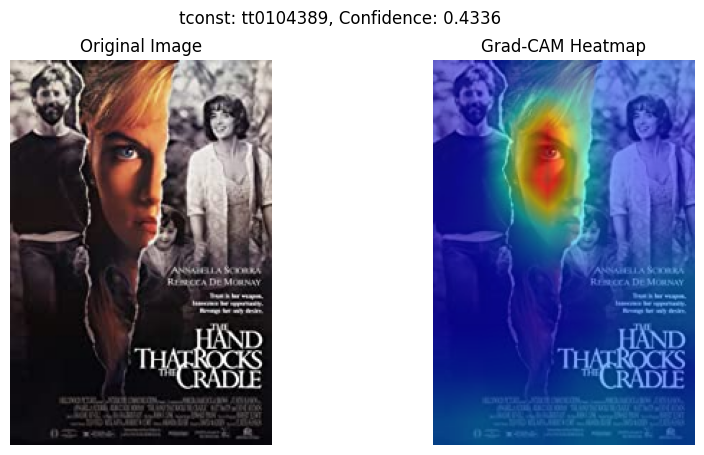

Generating Grad-CAM for genre: Crime


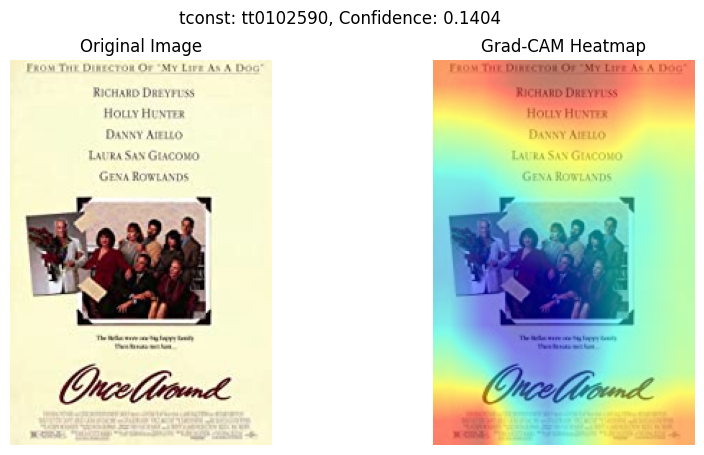

Generating Grad-CAM for genre: Animation


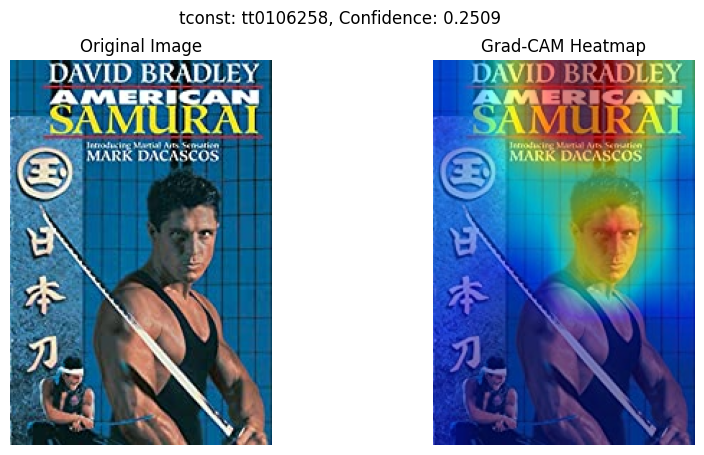

Generating Grad-CAM for genre: Documentary


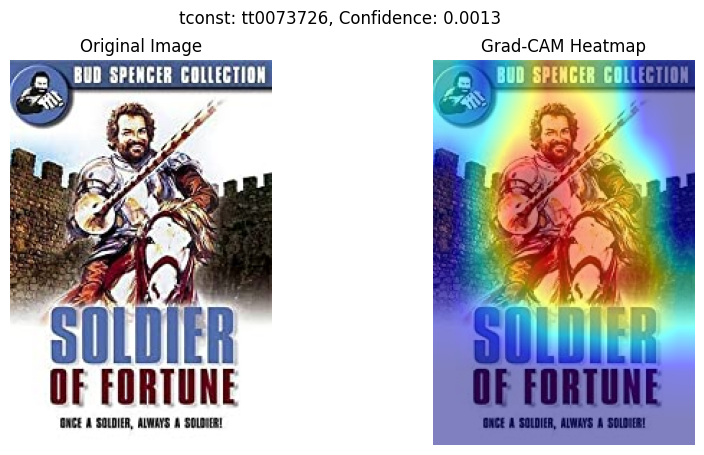

Generating Grad-CAM for genre: Biography


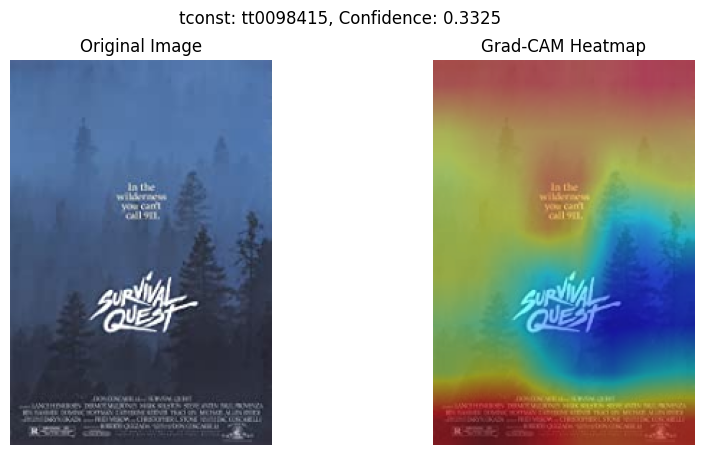

No predictions found for genre: Family
Generating Grad-CAM for genre: Horror


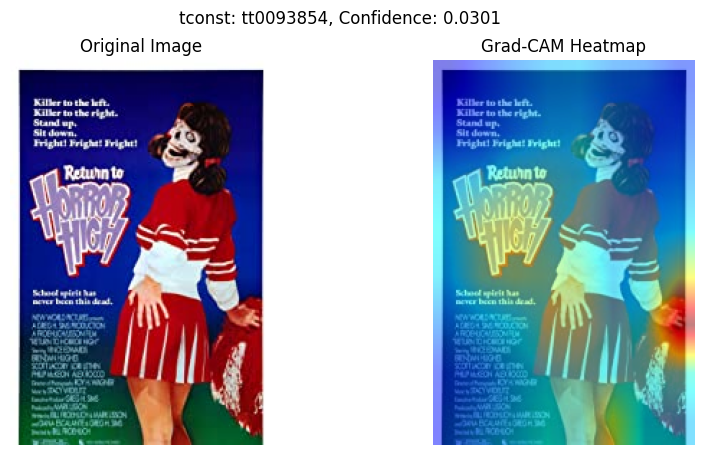

Generating Grad-CAM for genre: Drama


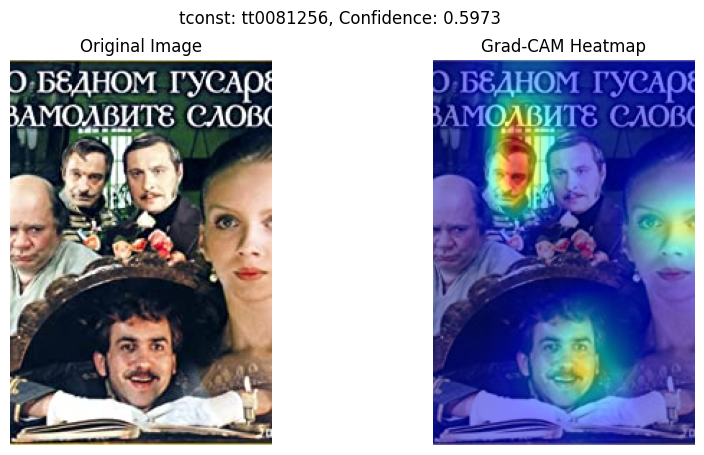

Generating Grad-CAM for genre: Adult


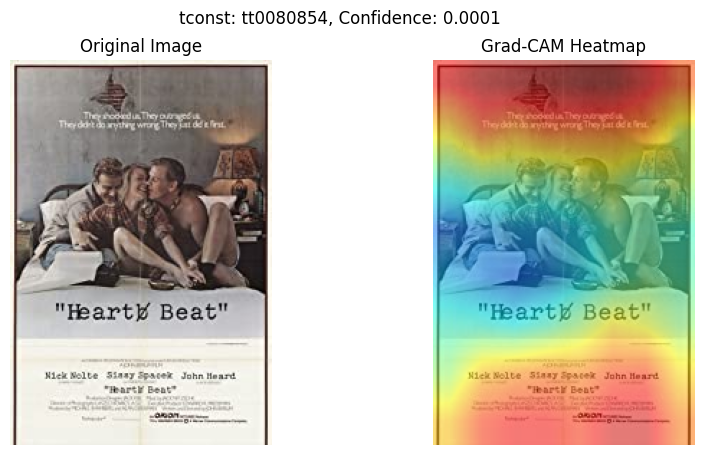

Generating Grad-CAM for genre: Adventure


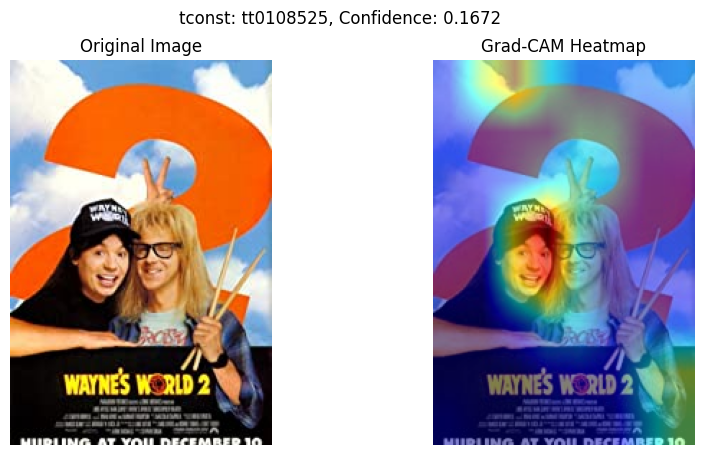

Generating Grad-CAM for genre: Action


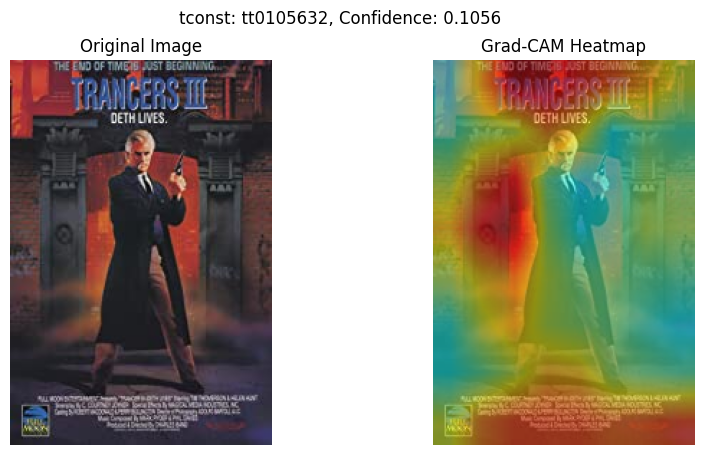

Generating Grad-CAM for genre: Comedy


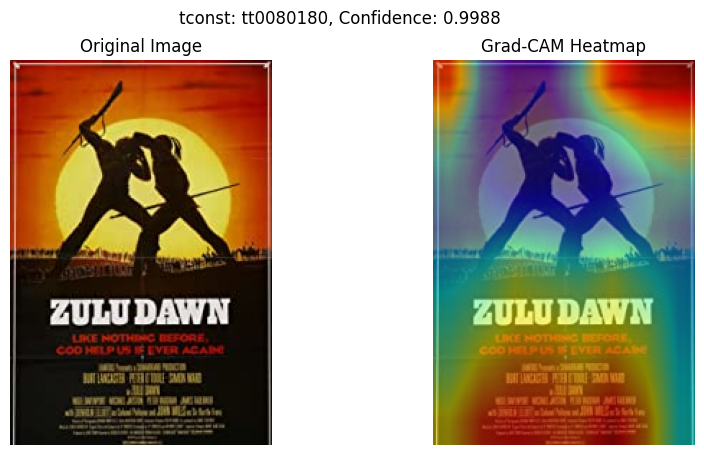

No predictions found for genre: Unknown


In [8]:
# Prepare the Image
def preprocess_image(img_path):
    if model_type == "inceptionv3":
        preprocess = transforms.Compose(
            [
                transforms.Resize((299, 299)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
    elif model_type == "resnet50":
        preprocess = ResNet50_Weights.IMAGENET1K_V2.transforms()

    img = Image.open(img_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Get the Gradients and Activations
def get_gradients_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def get_activations_hook(module, input, output):
    activations.append(output)

gradients = []
activations = []

target_layer = model.Mixed_7c
target_layer.register_forward_hook(get_activations_hook)
target_layer.register_backward_hook(get_gradients_hook)

# Compute Grad-CAM
def compute_gradcam(activations, gradients):
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    activations = activations[0].squeeze(0).detach()  # Remove batch dimension

    for i in range(len(pooled_gradients)):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=0).cpu()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)

    return heatmap

# Visualize the Heatmap side by side with original image
def visualize_heatmap(img_path, heatmap, tconst, confidence):
    original_img = cv2.imread(img_path)
    heatmap_resized = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.5, heatmap_resized, 0.5, 0)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    ax[1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    ax[1].axis("off")
    ax[1].set_title("Grad-CAM Heatmap")

    plt.suptitle(f"tconst: {tconst}, Confidence: {confidence:.4f}")
    plt.show()

# Function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(image_path, model):
    input_tensor = preprocess_image(image_path).to(device)  # Move input tensor to the same device as model

    gradients.clear()
    activations.clear()

    output = model(input_tensor)
    pred_class = output.argmax().item()

    model.zero_grad()
    one_hot_output = torch.zeros((1, output.size()[-1]), dtype=torch.float32).to(device)  # Ensure the tensor is on the same device
    one_hot_output[0][pred_class] = 1
    output.backward(gradient=one_hot_output)

    heatmap = compute_gradcam(activations, gradients)
    return heatmap

# Process each genre and generate heatmap
for genre, data in best_predictions.items():
    image_path = data["image_path"]
    tconst = data["tconst"]
    confidence = data["confidence"]
    if image_path is not None:
        print(f"Generating Grad-CAM for genre: {genre}")
        heatmap = generate_gradcam_heatmap(image_path, model)
        visualize_heatmap(image_path, heatmap, tconst, confidence)
    else:
        print(f"No predictions found for genre: {genre}")